<a href="https://colab.research.google.com/github/jasreman8/LLMs-For-RAGs-II/blob/main/Multimodal_RAG_Pipeline_for_PDF_Knowledge_Bases_(Text%2C_Tables%2C_Charts)_with_Evaluation_%26_Query_Expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using LLMs for Retrieval-Augmented Generation (Part 2)

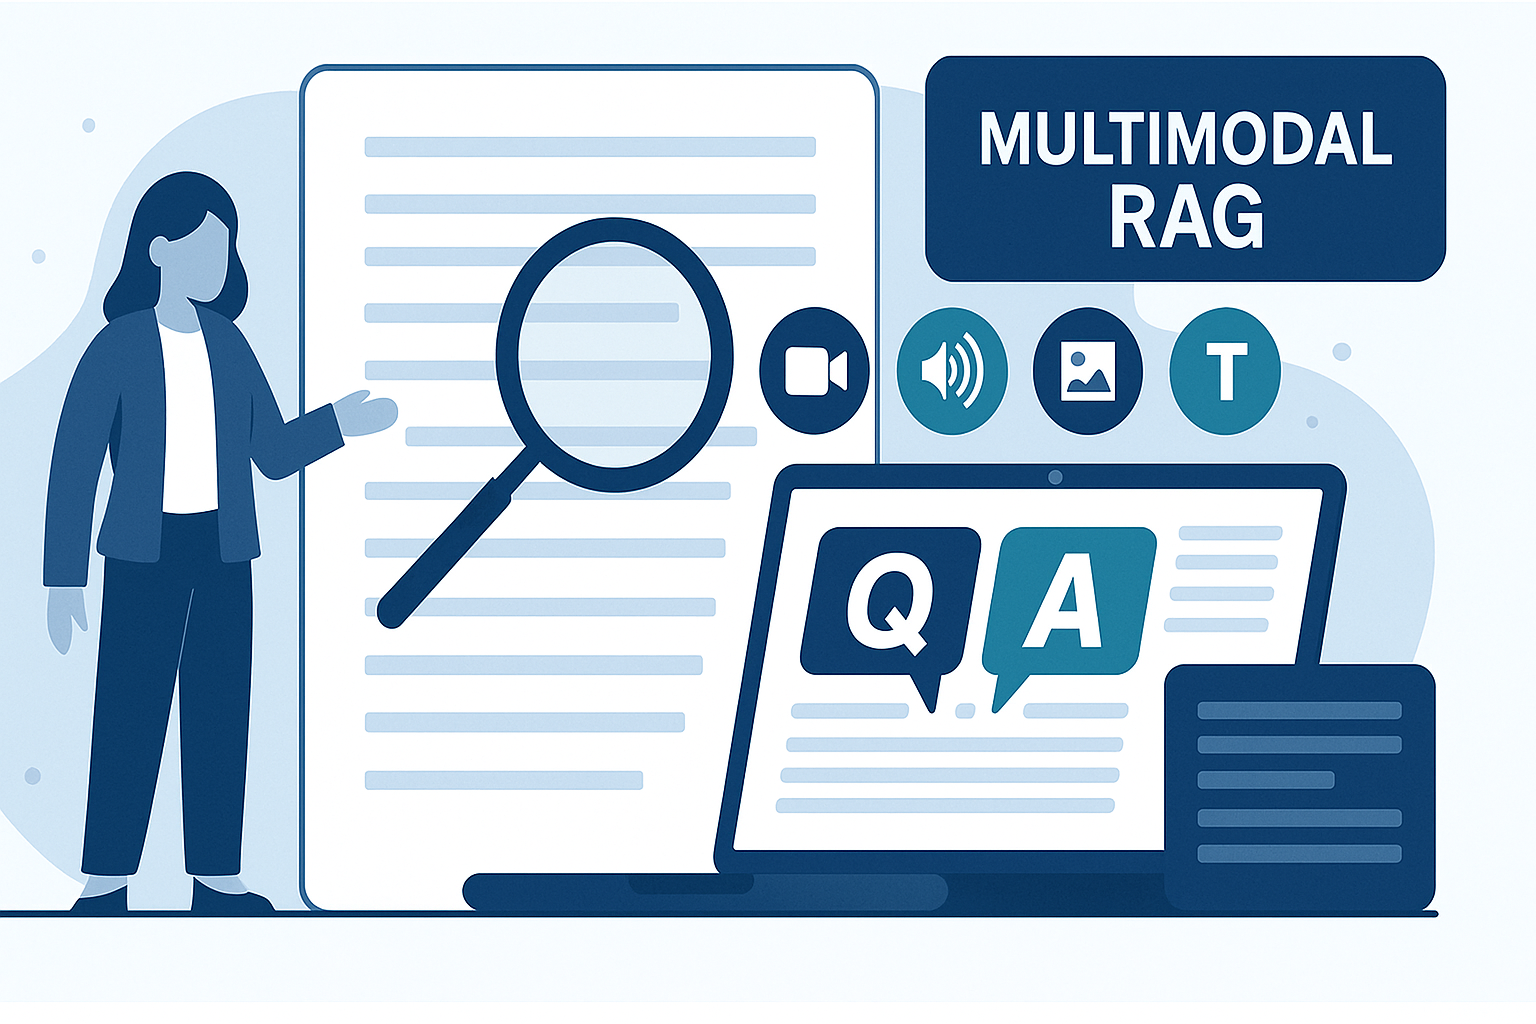

# Business Context

## Multi-Model RAG System

**Problem Scenario**:

The [Integrated Food Security Phase Classification (IPC)](https://www.ipcinfo.org/) is a global, multi-stakeholder initiative that enhances food security and nutrition analysis for informed decision-making.

Developed through collaboration among 15 expert organizations, the IPC Manual clarifies definitions like "Famine" and "Famine Likely" and strengthens evidence-based classification methods using international standards.

The manual is a complex resource containing detailed textual data, tables, charts, and diagrams.

Due to its multimodal and dense nature, analysts, policymakers, and field workers often find it challenging to quickly navigate and extract precise information, hindering timely and effective responses in food security and nutrition assessments.


# Objective

**Proposed Solution**:

To address these challenges, we propose implementing a multimodal Retrieval-Augmented Generation (RAG) system tailored to the IPC Technical Manual dataset.

This will allow users to ask natural language questions and receive  context-grounded answers that integrate both textual and visual information from the manual.

By leveraging multimodal retrieval and generation, the system will enhance accessibility and understanding of the manual's complex content and will empower humanitarian actors to make faster, more informed decisions, improving the effectiveness of food security and nutrition interventions worldwide.


We'll utilize LlamaParse to set up the document extraction process for the multimodal RAG pipeline.

The instructions to set up LlamaParse and set up an API Key is below.

# Installing and Importing the Necessary Libraries

In this section, we install and import libraries required to run the notebook:

- The `openai` package provides the official OpenAI API client for accessing models like GPT-4, Whisper, DALL·E, including its embedding models

- The `tiktoken`	library provides access to OpenAI's tokenizer models, crucial for chunking and token counting

- The `pypdf` library parses and extracts text from PDF files — useful for document ingestion

- LangChain is a GenAI framework to build applications with LLMs using chains and agents.
  - `langchain` is the core library that provides access to various LangChain abstractions
  - `langchain-community` provides access to 3rd-party integrations (e.g., different vector stores, tools)
  - `langchain-chroma` provides specific integration to use ChromaDB as the vector store backend in LangChain
  - `langchain-openai` module provides a plug-in interface for LangChain to call OpenAI's LLMs using standardized interface

- `chromadb` library provides access to ChromaDB vector database, which is a fast, vector database optimized for retrieval in RAG systems

- `llama-parse` library enables unstructured documents to be parsed into structured formats (e.g., markdown, JSON) via LlamaParse Cloud.

- `deepeval` is an evaluation toolkit that can be used to assess quality, relevance, and faithfulness of LLM responses.

- `llama-index-core` is a python library for indexing and querying data using LLMs.

- `llama-index-readers-file` is a LlamaIndex module to load content from files like PDFs, TXT, DOCX, etc.

In [1]:
!uv pip install -qU numpy==2.0.2 \
                pandas==2.3.1 \
                openai==1.66.3 \
                tiktoken==0.9.0 \
                pypdf==5.4.0 \
                langchain==0.3.23 \
                langchain-community==0.3.19 \
                langchain-chroma==0.2.4 \
                langchain-openai==0.3.9 \
                langchain-cohere==0.4.4 \
                cohere==5.14 \
                chromadb==1.0.9 \
                lark==1.2.2 \
                llama-parse==0.6.23 \
                deepeval==2.9.2 \
                llama-index-core==0.12.29 \
                llama-index-readers-file==0.4.8 \
                pillow==11.3.0 \
                protobuf==3.20.*

Importing the relevant libraries

In [2]:
import base64
import os, time
from typing import List
import chromadb
from openai import OpenAI, RateLimitError


from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_cohere import CohereRerank
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.retrievers.document_compressors import CrossEncoderReranker

from llama_parse import LlamaParse

from google.colab import userdata

from pprint import pprint

from deepeval import evaluate
from deepeval.test_case import LLMTestCase
from deepeval.dataset import EvaluationDataset
from deepeval.metrics import AnswerRelevancyMetric, FaithfulnessMetric, ContextualRelevancyMetric
from deepeval.metrics import ContextualPrecisionMetric, ContextualRecallMetric

import nest_asyncio; nest_asyncio.apply()

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


## Dataset Details

The `IPC Technical Manual Version 3.1` discusses evidence and standards for better food security and nutrition decisions. It contains more than 200 pages of text, tables, and images.

In [3]:
file_name = 'IPC_Technical_Manual_3_Final'
pdf_file_path = file_name +'.pdf'
doc_info = "Integrated Food Security Phase Classification (IPC) Technical Report"

Loading the API Keys from Colab secrets

In [4]:
openai_api_key = userdata.get('my_api_key')
llamaparse_api_key = userdata.get('llamaparse_api_key')

The following code adds the API Keys to the Environment Variables

In [5]:
os.environ['OPENAI_API_KEY'] = userdata.get('my_api_key')

os.environ['COHERE_API_KEY'] = userdata.get('cohere_api_key')

Defining the OpenAI client, the chat model and the embedding model.

In [6]:
# LLM model
model_name = 'gpt-4o-mini'  # Lightweight, fast version of GPT-4o optimized for performance

# Instantiate the low-level OpenAI client with your API key and base URL
client = OpenAI(
    api_key=openai_api_key,  # Securely retrieved from environment or notebook
)

# Initialize the ChatOpenAI LLM interface with specified model and parameters
llm = ChatOpenAI(
    api_key=openai_api_key,
    model=model_name,        # GPT-4o-mini for chat-based responses
    temperature=0.4          # Controls randomness: lower = more focused output
)

# Initialize the embedding model used for converting text to vector form
embedding_model = OpenAIEmbeddings(
    api_key=openai_api_key,
    model='text-embedding-3-small'  # Lightweight embedding model for efficient retrieval
)

## Multimodal Parsing using LlamaParse



To enable efficient parsing of multimodal PDF files, we utilize llamaparse, a service hosted on [LlamaCloud](https://cloud.llamaindex.ai/login).

Prior to processing documents, it is a pre-requisite to generate a LlamaCloud API key to authenticate requests.

Let's extract the text, images and tables from the pdf dataset.

In [7]:
parser = LlamaParse(
    result_type="markdown",
    parsing_instruction="Provided {}".format(doc_info),
    skip_diagonal_text=True,
    fast_mode=False,
    num_workers=9,
    check_interval=10,
    api_key=llamaparse_api_key
)

# Start parsing the file
json_objs = parser.get_json_result(pdf_file_path)

Started parsing the file under job_id 8b3860f5-5143-45a5-9d24-0920d4637096


Parser uploads this pdf file onto [LlamaCloud](https://cloud.llamaindex.ai/login) where we can track progress of the parsing job. The different elements of the parsed PDF file can also be viewed.

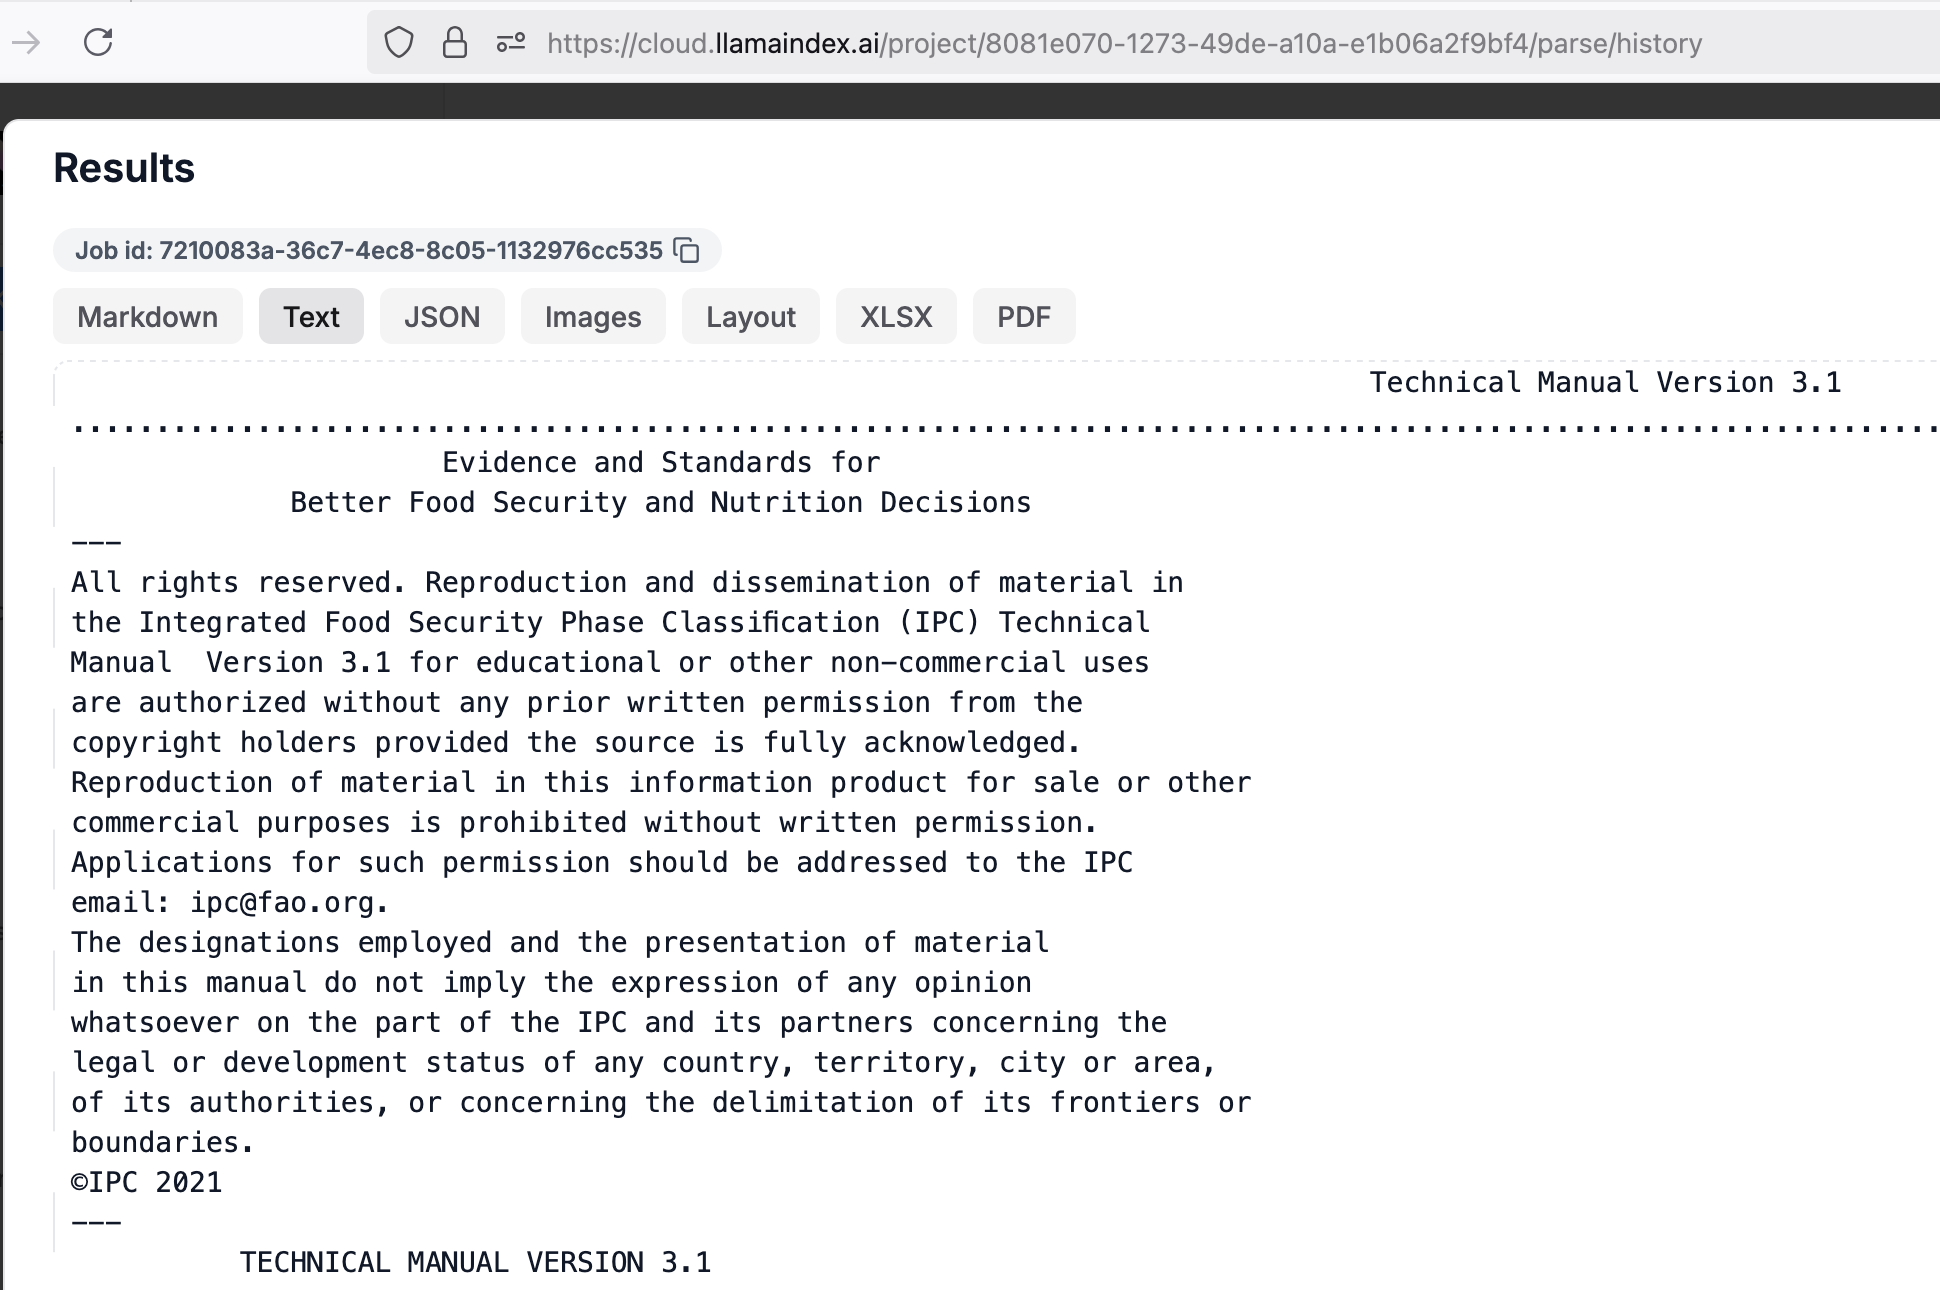

In [8]:
type(json_objs)

list

In [9]:
len(json_objs)

1

In [10]:
# Inspecting a parsed page
json_objs[0]['pages'][18]

{'page': 19,
 'text': 'IPC TECHNICAL MANUAL VERSION 3.1\n\n1.1 WHAT THE IPC IS\n\nFigure 1: What the IPC is        The Integrated Food Security Phase Classiﬁcation (IPC) is a common\n                                 global scale for classifying the severity and magnitude of food\nThe IPC is:                      insecurity and malnutrition. It is the result of a partnership of various\n• a process to build an          organizations at the global, regional and country levels dedicated\n evidence-based technical        to developing and maintaining the highest possible quality in food\n consensus among key             security and nutrition analysis. Increasingly, the IPC is the international\n stakeholders;                   standard for classifying food insecurity and malnutrition.\n• an approach to                 The IPC is a ‘big picture’ classification  focusing on providing\n consolidate wide-ranging        information that is constantly required by stakeholders around the\n evide

`llamaparse` extracts document elements pagewise, storing text under `md` and `text`, images under `images`, and tables as type `table`.

Let us now extract the text and tables in the document by looping over the extracted pages.

In [11]:
# Extract page-wise content by iterating over the extracted pages.
pages_list = json_objs[0]["pages"]

In [12]:
# should match with number of pages in input pdf
len(pages_list)

229

In [13]:
## To see the complete parsed output
# pages_list

### Extract Text

In [14]:
# Collecting all the text in the pages into a list by page.
page_texts = []

for json_item in pages_list:
    current_page_text = f"Page {json_item['page']}: \n" + json_item['md'] + '\n'
    page_texts.append(current_page_text)

len(page_texts)

229

In [15]:
# Inspecting text collected from a page
page_texts[19]

'Page 20: \n# IPC Technical Manual Version 3.1\n\n## 1.2 Why It Is Needed\n\nIn the complex and multidisciplinary fields of food security and nutrition, there is a significant need for an analytical approach that is robust, transparent, comparable across different locations, and relevant for decision-making. The Integrated Food Security Phase Classification (IPC) has emerged as a global reference for classifying food insecurity and, increasingly, acute malnutrition. The IPC is valued because it is:\n\n1. **Generic**: Applicable in a variety of food security and nutrition situations and contexts.\n2. **Simple**: Practical and understandable at the field level, making it useful for multiple stakeholders.\n3. **Rigorous**: Established as an international standard.\n\n## 1.3 How It Works\n\nThe IPC utilizes available evidence through a transparent, traceable, and rigorous process. The requirements for evidence to complete classification have been developed with consideration for circumstan

### Extract Tables & Generate Descriptions  

Next, we will extract the **cleanly** parsed tables from the `pages_list` followed by generating their descriptions.

In [16]:
tables = {}
for json_item in pages_list: # iterates through each page in the pages_list
    current_title = None # initializes current_title to None for each page
    for component in json_item['items']: # iterates through each component (e.g., heading, table) within a page
        if component['type'] == 'heading' and 'Table' in component['value']: # checks if the component is a heading and contains the word "Table"
            current_title = component['value'] # if true, assigns the heading value to current_title
        elif component['type'] == 'table' and current_title: # checks if the component is a table and current_title is not None (meaning a valid heading was found)
            tables[current_title] = component['rows'] # if true, adds the table data to the tables dictionary using current_title as the key
            current_title = None # resets current_title to None to avoid adding subsequent tables with the same title
pprint(list(tables.keys()))

['Population Table Template',
 'Population Estimates Table',
 'Figure 86: Reliability Score Table – For Evidence to be Used in Chronic Food '
 'Insecurity Classifications (Tool 5)',
 'Acute Malnutrition Reference Table',
 'Example Table Format',
 'Data Table']


In [17]:
len(list(tables.keys()))

6

Let's inspect an extracted table.

In [18]:
tables.keys()

dict_keys(['Population Table Template', 'Population Estimates Table', 'Figure 86: Reliability Score Table – For Evidence to be Used in Chronic Food Insecurity Classifications (Tool 5)', 'Acute Malnutrition Reference Table', 'Example Table Format', 'Data Table'])

In [19]:
table_name =list(tables.keys())[0]
table_name

'Population Table Template'

In [20]:
pprint(tables[table_name])

[['Region',
  'Total Population',
  'Phase 1 (#people, %)',
  'Phase 2 (#people, %)',
  'Phase 3 (#people, %)',
  'Phase 4 (#people, %)',
  'Phase 5 (#people, %)',
  'Phase 3+ (#people, %)'],
 ['Region',
  '000,000',
  '000,000 (00%)',
  '000,000 (00%)',
  '000,000 (00%)',
  '000,000 (00%)',
  '000,000 (00%)',
  '000,000 (00%)'],
 ['Region',
  '000,000',
  '000,000 (00%)',
  '000,000 (35%)',
  '000,000 (00%)',
  '000,000 (00%)',
  '000,000 (00%)',
  '000,000 (00%)'],
 ['...', '...', '...', '...', '...', '...', '...', '...'],
 ['Grand Total',
  '00,000,000',
  '000,000 (00%)',
  '000,000 (00%)',
  '000,000 (00%)',
  '000,000 (00%)',
  '000,000 (00%)',
  '000,000 (00%)']]


Next, we will write a function to describe the rows of table as text in order to capture its contents.

In [21]:
def generate_table_description(tables, table_key):
    """Generates a description of a table using an OpenAI model.

    This function takes a dictionary of tables and a table key as input. It then
    constructs a prompt containing a system message and the table data.
    This prompt is sent to an OpenAI model, and the model's response is returned as
    the table description.

    Args:
        tables: A dictionary of tables.
        table_key: The key of the table to describe.

    Returns:
        A string containing the description of the table. If an error occurs
        during the OpenAI API call, an empty string is returned.
    """

    if table_key not in tables:
        return f"Error: Table key '{table_key}' not found in tables dictionary"

    table_describer_system_message = f"""
You are tasked to explain for {doc_info} document.
You are required to generate a detailed description of rows of tables presented to you as the input.
Be detailed in your description and describe ALL the rows of the table presented to you.
The input will contain the title of the table followed by a list of rows in the table.
Remember to include the title of the table in your output.
Do not add any text other than the title and the description of the table in your output.
"""

    table_description_prompt = [
        {'role': 'developer', 'content': table_describer_system_message},
        {'role': 'user', 'content': table_key + str(tables[table_key])}
    ]

    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=table_description_prompt,
            temperature=0
        )
        description = response.choices[0].message.content
        return description
    except Exception as e:
        description = ''
        return description

In [22]:
# Generating the description of a table
pprint(generate_table_description(tables,table_name))

('Population Table Template\n'
 '\n'
 'This table presents a structured overview of the population distribution '
 'across different regions, categorized by the Integrated Food Security Phase '
 'Classification (IPC) phases. The columns in the table include the '
 'following:\n'
 '\n'
 '1. **Region**: This column identifies the specific geographical area or '
 'region being analyzed. Each row corresponds to a different region, allowing '
 'for a comparative analysis of food security status across various '
 'locations.\n'
 '\n'
 '2. **Total Population**: This column indicates the total number of people '
 'residing in each region, expressed in thousands (000,000). It provides a '
 'baseline for understanding the scale of the population affected by food '
 'security issues.\n'
 '\n'
 '3. **Phase 1 (#people, %)**: This column shows the number of people in Phase '
 '1 of food security, which represents the least severe level of food '
 'insecurity. The data is presented both as a count of

In [23]:
# Generating description for all the extracted tables
table_descriptions_1 = []
table_descriptions_1 = [generate_table_description(tables, table_key) for table_key in tables.keys()]

In [24]:
table_descriptions_1[3]

'**Acute Malnutrition Reference Table**\n\nThis table outlines the classification of acute malnutrition into five distinct phases, each characterized by specific prevalence rates, mortality and morbidity conditions, and priority response objectives.\n\n1. **Phase Name and Description**: This row lists the different phases of acute malnutrition, ranging from Phase 1 (Acceptable) to Phase 5 (Extremely Critical). Each phase represents a level of severity in the malnutrition situation.\n\n2. **Prevalence of Acute Malnutrition**: This row details the percentage of children who are acutely malnourished in each phase:\n   - **Phase 1: Acceptable**: Less than 5% of children are acutely malnourished, indicating a healthy nutritional status.\n   - **Phase 2: Alert**: 5-9.9% of children are acutely malnourished, suggesting a concerning but manageable situation.\n   - **Phase 3: Serious**: 10-14.9% of children are acutely malnourished, indicating a significant public health issue that requires att

### Extract Images & Generate Descriptions

In [25]:
# Downloading all the parsed images
image_dicts = parser.get_images(
    json_objs,
    download_path="images"
)

> Images for page 1: []
> Images for page 2: []
> Images for page 3: [{'name': 'img_p2_1.jpg', 'height': 16.209, 'width': 16.275, 'x': 235.138, 'y': 734.229, 'original_width': 59, 'original_height': 59, 'rotation': 351}, {'name': 'img_p2_2.png', 'height': 24.687, 'width': 41.392, 'x': 337.252, 'y': 753.528, 'original_width': 173, 'original_height': 103, 'rotation': 0, 'ocr': [{'x': 11, 'y': 65, 'w': 152, 'h': 29, 'confidence': 1, 'text': 'for every child'}, {'x': 12, 'y': 15, 'w': 112, 'h': 34, 'confidence': 0.999, 'text': 'unicef'}]}, {'name': 'img_p2_3.png', 'height': 21.391, 'width': 54.45, 'x': 276.632, 'y': 754.8, 'original_width': 227, 'original_height': 90, 'rotation': 0, 'ocr': [{'x': 88, 'y': 67, 'w': 132, 'h': 17, 'confidence': 0.98, 'text': 'Centroamericana'}, {'x': 88, 'y': 56, 'w': 132, 'h': 14, 'confidence': 0.978, 'text': 'Sislema de Ia Integraclon'}, {'x': 10, 'y': 42, 'w': 5, 'h': 7, 'confidence': 0.647, 'text': '1'}, {'x': 84, 'y': 5, 'w': 137, 'h': 54, 'confidence': 

Let us now look at the information available about a specific image.

In [26]:
image_dicts[0]

{'name': 'img_p2_1.jpg',
 'height': 16.209,
 'width': 16.275,
 'x': 235.138,
 'y': 734.229,
 'original_width': 59,
 'original_height': 59,
 'rotation': 351,
 'path': 'images/8b3860f5-5143-45a5-9d24-0920d4637096-img_p2_1.jpg',
 'job_id': '8b3860f5-5143-45a5-9d24-0920d4637096',
 'original_file_path': 'IPC_Technical_Manual_3_Final.pdf',
 'page_number': 3}

Let us now write a function to generate a detailed description of an image.

In [27]:
def image_describer(image_file_path):
    """Generates a detailed description of an image using LLM.

    This function takes the file path of an image as input, reads the image data,
    encodes it to base64, and constructs a data URI. It then sends a prompt
    containing the image data URI to GPT-4o-mini. The model's
    response, which contains a detailed description of the image, is returned.

    Args:
        image_file_path: The file path of the image to describe.

    Returns:
        A string containing the description of the image generated
    """

    with open(image_file_path, 'rb') as image_file:
        image_data = image_file.read()

    # Encode the binary image data to base64
    base64_encoded_data = base64.b64encode(image_data).decode('utf-8')

    # Construct the data URI
    data_uri = f"data:image/png;base64,{base64_encoded_data}"

    image_description_system_message = f"""
    You are tasked to explain images present in the {doc_info} document.
    You are required to generate a detailed description of the image presented to you as the input.
    Be detailed in your description and describe the image presented to you.
    Do not add any text other than the description of the image in your output.
    """

    image_description_prompt = [
        {
            'role': 'system',
            'content': image_description_system_message
        },
        {
            'role': 'user',
            'content': [
                {'type': "image_url", "image_url": {'url': data_uri}}
            ]
        }
    ]

    response = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=image_description_prompt,
        temperature=0
    )

    return response.choices[0].message.content

Lets fetch the description of an image.

In [28]:
sample_image_path = image_dicts[4]['path']
image_describer(sample_image_path)

'The image features a logo that includes a stylized representation of the African continent in black, with green accents. Surrounding the continent is a pair of green olive branches, which are often associated with peace. Above the continent, the acronym "CILSS" is displayed in bold, uppercase letters. The overall design conveys a sense of unity and focus on Africa, likely representing an organization or initiative related to the continent.'

We shall now loop over all the paths of the downloaded images and create descriptions of all these images.

In [29]:
# image_descriptions = [image_describer(image_info['path']) for image_info in image_dicts]

def call_with_backoff(fn, *args, max_retries=8, base_sleep=1.0):
    for attempt in range(max_retries):
        try:
            return fn(*args)
        except RateLimitError:
            # Exponential backoff + small cushion
            sleep_s = base_sleep * (2 ** attempt)
            time.sleep(sleep_s)
    raise RuntimeError("Rate limit: retries exhausted")

image_descriptions = []

for image_info in image_dicts:
    desc = call_with_backoff(image_describer, image_info["path"])
    image_descriptions.append(desc)
    time.sleep(0.3)  # small pacing between calls


In [30]:
len(image_descriptions)

58

### Integrate Text, Tables & Images Descriptions

**Collecting all the text, table and image descriptions as single block of texts.**

In [31]:
# text
full_text = ''

for text in page_texts:
    full_text += ('\n---\n' + text)

# tables
all_table_descriptions = ''

for description in table_descriptions_1:
    all_table_descriptions += ('\n---\n' + description)

# images
all_image_descriptions = ''

for description in image_descriptions:
    all_image_descriptions += ('\n---\n' + description)

# defining text splitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=16
)

# adding the source of the text (i.e., document text, table or image) as metadata.
all_chunks = text_splitter.create_documents(
    [full_text, all_table_descriptions, all_image_descriptions],
    metadatas=[{'source': 'text'}, {'source': 'table_descriptions'}, {'source': 'image_descriptions'}]
)

In [32]:
len(all_chunks)

268

## RAG Q&A Application

As the multimodel data is chunked, we will use it to build a RAG Application over it.

We will create a Chroma vector database and populate it with records from the earlier created data chunks `all_chunks`

In [33]:
collection_name = file_name +'_collection'
db_path= "./"+file_name+"_db"

chromadb_client = chromadb.PersistentClient(
    path=db_path
)
# Creating a collection using Chroma client
vectorstore = Chroma(
    collection_name=collection_name,
    collection_metadata={"hnsw:space": "cosine"},
    embedding_function=embedding_model,
    client=chromadb_client,
    persist_directory=db_path
)
# confirming collection creation
chromadb_client.count_collections()

2

One collection is crated under `chromadb`

In [34]:
chromadb_client.list_collections()

[Collection(name=hypothetical_questions),
 Collection(name=IPC_Technical_Manual_3_Final_collection)]

Now we wil add the data(chunks) into vector DB

In [35]:
# Inserting each chunk with a unique id
unique_id_prefix= 'text_'

vectorstore.add_documents(
    documents=all_chunks,
    ids=[unique_id_prefix + str(i) for i in range(len(all_chunks))]
)

['text_0',
 'text_1',
 'text_2',
 'text_3',
 'text_4',
 'text_5',
 'text_6',
 'text_7',
 'text_8',
 'text_9',
 'text_10',
 'text_11',
 'text_12',
 'text_13',
 'text_14',
 'text_15',
 'text_16',
 'text_17',
 'text_18',
 'text_19',
 'text_20',
 'text_21',
 'text_22',
 'text_23',
 'text_24',
 'text_25',
 'text_26',
 'text_27',
 'text_28',
 'text_29',
 'text_30',
 'text_31',
 'text_32',
 'text_33',
 'text_34',
 'text_35',
 'text_36',
 'text_37',
 'text_38',
 'text_39',
 'text_40',
 'text_41',
 'text_42',
 'text_43',
 'text_44',
 'text_45',
 'text_46',
 'text_47',
 'text_48',
 'text_49',
 'text_50',
 'text_51',
 'text_52',
 'text_53',
 'text_54',
 'text_55',
 'text_56',
 'text_57',
 'text_58',
 'text_59',
 'text_60',
 'text_61',
 'text_62',
 'text_63',
 'text_64',
 'text_65',
 'text_66',
 'text_67',
 'text_68',
 'text_69',
 'text_70',
 'text_71',
 'text_72',
 'text_73',
 'text_74',
 'text_75',
 'text_76',
 'text_77',
 'text_78',
 'text_79',
 'text_80',
 'text_81',
 'text_82',
 'text_83',
 '

In [36]:
collection = chromadb_client.get_collection(collection_name)

In [37]:
# Count the number of records in the collection
collection.count()

268

In [38]:
# Inspect the first 2 records
collection.peek(limit=2)

{'ids': ['text_0', 'text_1'],
 'embeddings': array([[-0.00483101,  0.05339835,  0.08240303, ...,  0.04779574,
         -0.01999339,  0.02127009],
        [-0.0363163 ,  0.0130265 ,  0.07347471, ...,  0.05426392,
         -0.02030292,  0.00232898]]),
 'documents': ["---\nPage 1: \nIt seems like you've provided a snippet from a technical manual related to food security and nutrition. If you have specific questions or need information on a particular topic within this manual, please let me know how I can assist you!\n\n---\nPage 2: \nAll rights reserved. Reproduction and dissemination of material in the Integrated Food Security Phase Classification (IPC) Technical Manual Version 3.1 for educational or other non-commercial uses are authorized without any prior written permission from the copyright holders provided the source is fully acknowledged. Reproduction of material in this information product for sale or other commercial purposes is prohibited without written permission.\n\nApplicat

In [39]:
# To retrieve relevant records based on a user query
retriever = vectorstore.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

In [40]:
user_query = "What causes malnutrition, and how can we effectively eliminate it? Mention in brief."

In [41]:
relevant_document_chunks = retriever.invoke(user_query)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = "\n---\n".join(context_list)

In [42]:
context_for_query

"- **Food Security Dimensions**: This encompasses the four dimensions of the food security conceptual framework: availability, access, utilization, and stability. A general description of the food security context at national, sub-national, community, and household levels can be generated based on these dimensions. They determine the extent of food availability, accessibility, utilization, and the overall consistency of these factors over time (stability).\n\n### C. Immediate Causes\n- **Health Status**: The analysis considers main childhood illnesses according to the Integrated Management of Childhood Illnesses, such as malaria, diarrhoea, pneumonia, measles, and HIV/AIDS, as they directly contribute to acute malnutrition. Context-specific diseases (e.g., dengue) and disease outbreaks are also included in the analysis.\n\n- **Food Consumption**: Both the quality and quantity of food consumed by children are evaluated. It is acknowledged that adequate food security at the household lev

In [43]:
qna_system_message = f"""
You are an assistant who answers user queries about the {doc_info} document.
User input will include relevant context from the document to help you answer questions accurately.
The context will be delimited by: <Context> and </Context>.

User queries will be delimited by: <Question> and </Question>.

Follow these guidelines:
1. Answer questions **only** using the provided context. Do not speculate or invent details.
2. Keep answers concise and directly relevant to the question.
3. If the answer is not found in the context, respond: "I don't know."
4. Do not mention the context itself in your answer (e.g., avoid phrases like "According to the context...").
"""

qna_user_message_template = f"""
<Context>
Here are relevant excerpts from the {doc_info} Guide:
{{context}}
</Context>

<Question>
{{question}}
</Question>

Please answer the question using the context above. If the answer isn't available, say "I don't know."
"""

prompt = [
        {'role': 'developer', 'content': qna_system_message},
        {'role': 'user', 'content': qna_user_message_template.format(
            context=context_for_query,
            question=user_query
            )
        }
    ]

try:
    response = client.chat.completions.create(
            model=model_name,
            messages=prompt,
            temperature=0
        )

    prediction = response.choices[0].message.content.strip()
except Exception as e:
        prediction = f'Sorry, I encountered the following error: \n {e}'




In [44]:
prediction

'Malnutrition can be caused by a variety of factors, including:\n\n1. **Immediate Causes**: Poor food consumption (both quality and quantity) and health status (prevalence of diseases).\n2. **Underlying Causes**: Food security dimensions (availability, access, utilization), caring and feeding practices, and health services and environmental health.\n3. **Non-nutrition-related Causes**: Factors such as conflict and changes in livelihood.\n\nTo effectively eliminate malnutrition, it is essential to address these causes through targeted interventions that improve food security, enhance health services, promote proper feeding practices, and mitigate the impacts of conflict and economic instability.'

Modularizing the above code into two functions.
- `retrieve_rag_context` : For retrieving the relevant context from the VectorDB for a given user query.

- `generate_rag_answer`: For inferring the answer of the given user query from the retrieved context

These functions will be used in subsequent sections for context retrieval and answer generation, respectively.

In [45]:
def retrieve_rag_context(
    user_query: str,
    retriever=retriever
) -> list[str]:
    """
    Retrieves relevant document chunks using RAG.

    Args:
        user_query: Input question or query.
        retriever: The retriever object for querying the vector store.

    Returns:
        list: List of retrieved context strings.
    """
    try:
        relevant_document_chunks = retriever.invoke(user_query)
        return [d.page_content for d in relevant_document_chunks]

    except Exception as e:
        print(f"Error retrieving context: {str(e)}")
        return []

In [46]:
def generate_rag_answer(
    user_query: str,
    context_list: list[str],
    client=client,
    model_name=model_name,
    system_prompt=qna_system_message,
    user_prompt_template=qna_user_message_template
) -> str:
    """
    Generates a response using LLM based on retrieved context.

    Args:
        user_query: Input question or query.
        context_list: List of context strings retrieved by RAG.
        client: Client for the LLM API.
        model_name: Name of the LLM model to use.
        system_prompt: Template for the LLM system message.
        user_prompt_template: Template for the user message.

    Returns:
        str: Generated response from LLM
    """
    try:
        context_for_query = "\n---\n".join(context_list)

        # Prepare prompt
        prompt = [
            {'role': 'developer', 'content': system_prompt},
            {'role': 'user', 'content': user_prompt_template.format(
                context=context_for_query,
                question=user_query
            )}
        ]

        # Get LLM response
        response = client.chat.completions.create(
            model=model_name,
            messages=prompt,
            temperature=0
        )

        return response.choices[0].message.content.strip()

    except Exception as e:
        return f'Sorry, I encountered an error: {str(e)}'

Let's test these functions.

In [47]:
# Usage test
user_query = "What causes malnutrition, and how can we effectively eliminate it? Mention in brief."
contexts = retrieve_rag_context(user_query)
contexts

["- **Food Security Dimensions**: This encompasses the four dimensions of the food security conceptual framework: availability, access, utilization, and stability. A general description of the food security context at national, sub-national, community, and household levels can be generated based on these dimensions. They determine the extent of food availability, accessibility, utilization, and the overall consistency of these factors over time (stability).\n\n### C. Immediate Causes\n- **Health Status**: The analysis considers main childhood illnesses according to the Integrated Management of Childhood Illnesses, such as malaria, diarrhoea, pneumonia, measles, and HIV/AIDS, as they directly contribute to acute malnutrition. Context-specific diseases (e.g., dengue) and disease outbreaks are also included in the analysis.\n\n- **Food Consumption**: Both the quality and quantity of food consumed by children are evaluated. It is acknowledged that adequate food security at the household le

In [48]:
generate_rag_answer(user_query,contexts)

'Malnutrition can be caused by a variety of factors, including:\n\n1. **Immediate Causes**: Poor food consumption (both quality and quantity) and health status (prevalence of diseases).\n2. **Underlying Causes**: Food security dimensions (availability, access, utilization), caring and feeding practices, and health services and environmental health.\n3. **Non-nutrition-related Causes**: Factors such as conflict and changes in livelihood.\n\nTo effectively eliminate malnutrition, it is essential to address these causes through comprehensive interventions that improve food security, enhance health services, promote proper feeding practices, and mitigate the impacts of conflict and economic instability.'

## RAG Evaluation  

RAG application evaluation employs approaches depending on the availability/unavailability of Ground truth data.

Ground truth refers to the validated correct responses to user queries, also called gold answers. Multiple queries paired with their golden responses collectively form a Golden dataset, which shall be used as a benchmark to assess the quality of generated answers in RAG systems


A typical evaluation test case consist of,
 - User query
 - RAG generated response
 - Baseline validated answer(optional)

To evaluate RAG, one among below two RAG evaluation frameworks shall be used:

1. RAG Triad
2. RAGAS (**Retrieval Augmented Generation Assessment**)

Both frameworks provide holistic evaluation by combining multiple distinct metrics to score the performance of a RAG pipeline’s retriever and generator.



**RAG Triad Metrics**:
- **Answer Relevance** : Measures how well the final response answers the original question, ensuring the answer is on-topic and appropriate.
- **Faithfulness** (Groundedness) : Assesses whether the generated answer is well-supported by the retrieved context, checks for hallucinations or unsupported claims.
- **Contextual Relevance** : Evaluates how relevant the retrieved context is to the original query.


**RAGAS Metrics**:
- **Answer Relevancy** : Measures how relevant the generated answer is.
- **Faithfulness**: Assesses the factual accuracy of the answer relative to the retrieved context.
- **Contextual Precision** : Evaluates the precision of the retrieved context*.
- **Recall**: Measures the recall quality of the retrieved context*.

Note that a Golden answer is needed to measure Contextual Precision and Recall; hence, RAGAS evaluation is recommended when Golden example(s) are available.

### DeepEval
DeepEval is an open-source LLM evaluation framework that offers ready-to-use implementations of the metrics discussed above. Additionally, both generation and retrieval capabilities can be refined in order to improve and optimize evaluation scores.

Next, we will evaluate our RAG architecture using the RAG Triad.

**Considering we do not have any Golden output.**


### RAG Triad

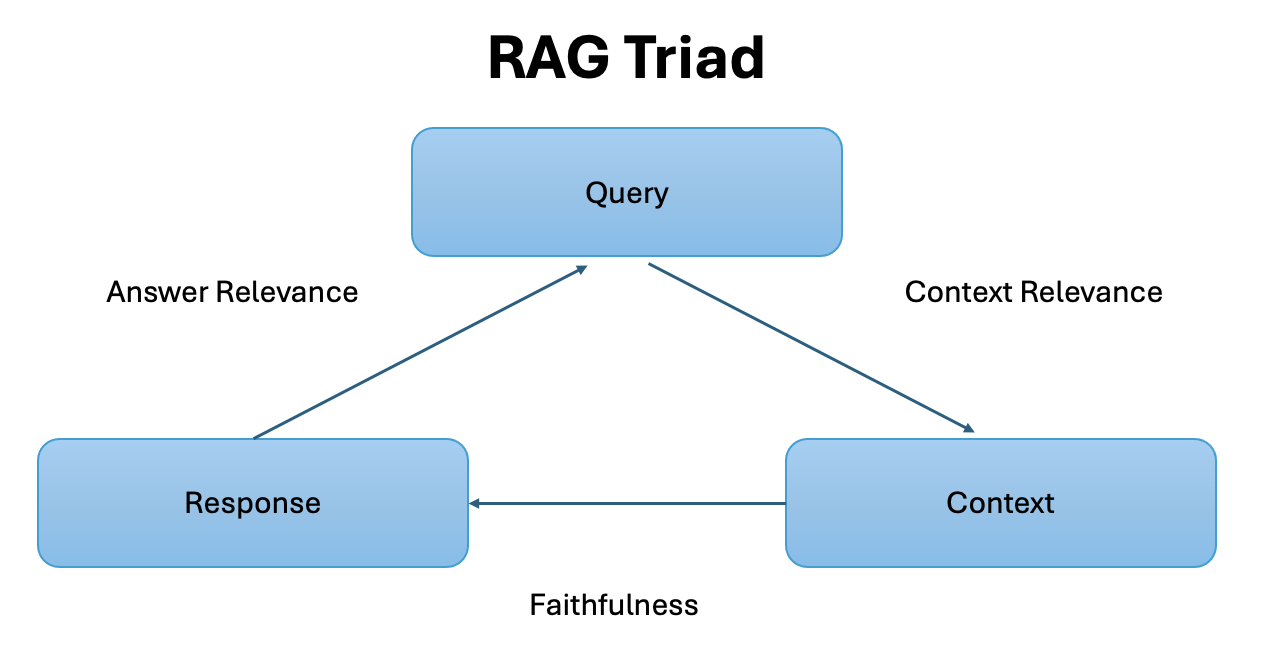

Lets first initialise the 3 metrics that RAG Triad uses.
The `threshold` parameter here, defines the minimum acceptable standard for an answer to pass evaluation against the chosen metric.

In [49]:
answer_relevancy = AnswerRelevancyMetric(
    threshold=0.7,
    model='gpt-4o',
    include_reason=True
)

#Groundedness
faithfulness = FaithfulnessMetric(
    threshold=0.7,
    model='gpt-4o',
    include_reason=True
)

contextual_relevancy = ContextualRelevancyMetric(
    threshold=0.7,
    model='gpt-4o',
    include_reason=True
)

#### Evaluate without Ground truth

**Single Test Case**

In [50]:
user_query = "Define a metric to measure malnutrition."
retrieved_context = retrieve_rag_context(user_query)
retrieved_context

["- **Livelihood Assets**: In the Sustainable Livelihoods Framework, livelihood assets are defined under the following five categories:\n- **Human**: Health and nutrition status; physical capacity; skills; level of education; etc.\n- **Social**: Household, gender, kinship and other networks; community groups; values and attitudes; etc.\n- **Financial**: Income; credit and loans; savings; liquid assets; etc.\n- **Physical**: Productive assets such as tools and equipment; stores; housing; livestock; infrastructure; etc.\n- **Natural**: Land; water; forests; etc. (World Food Programme. Food Security Assessment Learning Repository)\n\n- **Livelihood Group**: A group of people who share the same basic means of livelihood and lifestyle—i.e., the same main subsistence activities, main income activities, and social and cultural practices—and who face the same risks of food and nutrition insecurity. (World Food Programme. Food Security Assessment Learning Repository)\n\n- **Livelihood Strategie

In [51]:
answer = generate_rag_answer(user_query,retrieved_context)
answer

'A metric to measure malnutrition is the Global Acute Malnutrition (GAM) based on Weight-for-Height Z score (WHZ) or Mid-Upper Arm Circumference (MUAC). GAM is defined as WHZ < -2 or the presence of oedema, and for MUAC, it is defined as MUAC < 125 mm or the presence of oedema. The prevalence of acute malnutrition is categorized into phases based on the percentage of children who are acutely malnourished, with specific thresholds for each phase.'

To construct a test case, we will utilize the `LLMTestCase` abstraction provided by the `deepeval` framework.

In [52]:
test_case_without_golden_output = LLMTestCase(
    input=user_query,
    actual_output=answer,
    retrieval_context=retrieved_context
)

The performance of the RAG system can be evaluated against the test case using `evaluate` function call.

In [53]:
results = evaluate(
    test_cases=[test_case_without_golden_output],
    metrics=[answer_relevancy, faithfulness, contextual_relevancy]
)

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:08,  8.75s/test case]

False !!!!!!!!!!!!


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the response perfectly aligns with the input request, providing a clear and relevant definition of a metric to measure malnutrition without any irrelevant information. Great job on staying focused and concise!, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because there are no contradictions, indicating a perfect alignment between the actual output and the retrieval context. Great job maintaining accuracy and consistency!, error: None)
  - ❌ Contextual Relevancy (score: 0.6976744186046512, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 0.70 because while the retrieval context includes relevant information on malnutrition metrics such as 'Global Acute Malnutrition (GAM) based on Weight-for-Height Z score (WHZ)' an

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

 **Observation : '*Contextual Relevancy*' score  is less than desired threshold here. Hence, it needs improvement.**

Above evaluation codes have been modularized into the `rag_triad_evaluation` function next, by which the RAG architecture is evaluated using the RAG triad approach. A user query, RAG response context list, and an optional golden answer are required as inputs. Both scenarios—with and without a golden answer—are incorporated to ensure generality. This method will be leveraged for RAG evaluation in subsequent sections.

In [54]:
def rag_triad_evaluation(user_input: str,
                         prediction: str,
                         context_list: list,
                         golden_output: str = None):
    """
    Evaluate RAG performance using multiple metrics.

    Args:
        user_input (str): The input query/prompt given to the RAG system
        prediction (str): The output generated by the RAG system
        context_list (list): List of context chunks used for retrieval
        golden_output (str, optional): The expected/ideal output. Defaults to None.

    Returns:
        dict: Evaluation results containing metrics scores
    """
    # Default golden output if not provided
    if golden_output is None:
      #test_case_withour_golden_output
      test_case = LLMTestCase(
        input=user_input,
        actual_output=prediction,
        retrieval_context=context_list
    )

    else:
      test_case = LLMTestCase(
        input=user_input,
        expected_output=golden_output,
        actual_output=prediction,
        retrieval_context=context_list
    )

    # Evaluate metrics
    results = evaluate(
        test_cases=[test_case],
        metrics=[answer_relevancy, faithfulness, contextual_relevancy]
    )

    return None

**Batch Evaluation**

Let's now perform the evaluation on a list containing multiple questions.

In [55]:
test_queries = [
    "What are the main causes of acute food insecurity in crisis areas?",
    "Quantify adequate vs inadequate food intake?",
    "What are the 3 most effective solution to eradicate poverty" ]

for user_query in test_queries :
    retrieved_context = retrieve_rag_context(user_query)
    actual_output = generate_rag_answer(user_query,retrieved_context)
    rag_triad_evaluation(user_query,actual_output, retrieved_context)

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]

False !!!!!!!!!!!!


Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:07,  7.99s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the response perfectly addressed the question about the main causes of acute food insecurity in crisis areas without any irrelevant information. Great job on staying focused and relevant!, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because there are no contradictions, indicating a perfect alignment between the actual output and the retrieval context. Great job maintaining accuracy and consistency!, error: None)
  - ✅ Contextual Relevancy (score: 0.7555555555555555, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 0.76 because while the retrieval context provides some relevant insights into the causes of acute food insecurity, such as 'ongoing conflict and sieges impacting food availability' an

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:08,  8.64s/test case]

False !!!!!!!!!!!!


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the response perfectly addresses the input without any irrelevant statements, providing a clear and focused explanation on quantifying adequate versus inadequate food intake. Great job on staying on point!, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because there are no contradictions, indicating a perfect alignment between the actual output and the retrieval context. Great job maintaining accuracy and consistency!, error: None)
  - ❌ Contextual Relevancy (score: 0.5681818181818182, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 0.57 because while there are relevant statements like 'Women consuming foods from ≥5 food groups have a greater likelihood of meeting their micronutrient needs' and 'Adequate Dietary E

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-uf0bBOJevWTuqVInCHg5x7nb on tokens per min (TPM): Limit 30000, Used 30000, Requested 278. Please try again in 556ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-uf0bBOJevWTuqVInCHg5x7nb on tokens per min (TPM): Limit 30000, Used 30000, Requested 681. Please try again in 1.362s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-uf0b

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-uf0bBOJevWTuqVInCHg5x7nb on tokens per min (TPM): Limit 30000, Used 30000, Requested 681. Please try again in 1.362s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-uf0bBOJevWTuqVInCHg5x7nb on tokens per min (TPM): Limit 30000, Used 30000, Requested 1004. Please try again in 2.008s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-uf0bBOJevWTuqVInCHg5x7nb on tokens per min (TPM): Limit 30000, Used 30000, Requested 254. Please 

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-uf0bBOJevWTuqVInCHg5x7nb on tokens per min (TPM): Limit 30000, Used 30000, Requested 1004. Please try again in 2.008s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-uf0bBOJevWTuqVInCHg5x7nb on tokens per min (TPM): Limit 30000, Used 29300, Requested 1004. Please try again in 608ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 4 time(s)...
Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:42, 42.34s/test case]

False !!!!!!!!!!!!


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the response perfectly addresses the question by providing three effective solutions to eradicate poverty without any irrelevant information. Great job on staying focused and relevant!, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because there are no contradictions, indicating a perfect alignment between the actual output and the retrieval context. Great job maintaining consistency!, error: None)
  - ❌ Contextual Relevancy (score: 0.45454545454545453, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 0.45 because while some statements like 'Household Economy Analysis (HEA)' and 'Livelihood Strategies' touch on economic aspects, the majority of the context focuses on food security and health, which are not directly

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Clearly, the RAG Architecture needs improvements in its  **Contextual Relevancy** capability.
Hence, lets try to enhance retrival performance of our RAG Architecture.

## Enhancing Retrieval Performance

### Query Expansion

In this apprach, the LLM is asked to generate variations of the original user query. Each of these variations is then used to retrieve the relevant context. The final context used is the unique set of documents retrieved across all the query expansions.

Below function implements *Query Expansion* approach.

In [56]:
def query_expansion(
    user_input: str,
    doc_info: str = doc_info,
    llm: ChatOpenAI = llm,
    no_of_variations: int = 3  # Default to 3 if not specified
) -> List[str]:
    """
    Expands a user's query into multiple variations using an LLM and retrieves relevant documents.

    Args:
        user_input: The original user question.
        doc_info: Context for the LLM.
        llm: Initialized ChatOpenAI instance.
        no_of_variations: Number of query variations to generate (default: 3).

    Returns:
        List of unique document contexts retrieved from the expanded queries.
    """
    # System prompt with dynamic doc_details and no_of_questions
    query_expansion_system_message = f"""
    You are a support assistant who answers user queries about the {doc_info}.
    Perform query expansion on the question below. If there are multiple common ways of phrasing a user question \
    or common synonyms for key words in the question, make sure to return multiple versions \
    of the query with the different phrasings.

    If there are acronyms or words you are not familiar with, do not try to rephrase them.

    Return {no_of_variations} versions of the question as a list.
    Generate only a list of questions, each question in a new line.
    Do not number the list of questions or use bullet points.
    Do not mention anything before or after the list.
    """

    # User message template
    user_message_template = """
    <Question>
    {question}
    </Question>
    """

    # Generate query expansions via LLM
    query_expansions = llm.invoke([
        ('system', query_expansion_system_message),
        ('user', user_message_template.format(question=user_input))
    ])

    # Parse LLM output into a list of queries
    query_expansions_list = query_expansions.content.strip().split("\n")

    # Retrieve documents for each expanded query
    expanded_context_list = []
    for query in query_expansions_list:
        expanded_context_list.extend([d.page_content for d in retriever.invoke(query)])

    # Remove duplicates and return
    return list(set(expanded_context_list))

In [57]:
user_query = "Define a metric to measure malnutrition."
context_list  = query_expansion(user_query)
context_list

['### Phases of Acute Malnutrition\n\n| Phase Name and Description | Phase 1: Acceptable | Phase 2: Alert | Phase 3: Serious | Phase 4: Critical | Phase 5: Extremely Critical |\n|----------------------------|---------------------|----------------|------------------|-------------------|-----------------------------|\n| **Prevalence of Acute Malnutrition** | Less than 5% of children are acutely malnourished. | 5-9.9% of children are acutely malnourished. | 10-14.9% of children are acutely malnourished. | 15-29.9% of children are acutely malnourished. | 30% or more children are acutely malnourished. |\n| **Mortality and Morbidity** | The situation is stable. | The situation is progressively deteriorating. | Elevated or increasing mortality and morbidity levels. | Compromised individual food consumption. | Widespread morbidity and/or very large individual food consumption gaps. |\n| **Priority Response Objective** | Maintain low prevalence of acute malnutrition. | Strengthen response capac

In [58]:
prediction = generate_rag_answer(user_query,context_list)
prediction

'A metric to measure malnutrition is Global Acute Malnutrition (GAM), which can be assessed using the following indicators:\n- **Weight-for-Height Z-score (WHZ)**: Children with WHZ < -2 standard deviations are reported as GAM.\n- **Mid-Upper Arm Circumference (MUAC)**: Children with MUAC < 125mm are also classified as GAM.\n- **Bilateral Pitting Oedema**: The presence of oedema is another indicator of malnutrition.'

Lets Use this context and prediction to  check if any improvemnt in score is there

In [59]:
rag_triad_evaluation(user_query,prediction, context_list)

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-uf0bBOJevWTuqVInCHg5x7nb on tokens per min (TPM): Limit 30000, Used 30000, Requested 620. Please try again in 1.24s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-uf0bBOJevWTuqVInCHg5x7nb on tokens per min (TPM): Limit 30000, Used 30000, Requested 228. Please try again in 456ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...


False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-uf0bBOJevWTuqVInCHg5x7nb on tokens per min (TPM): Limit 30000, Used 30000, Requested 228. Please try again in 456ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-uf0bBOJevWTuqVInCHg5x7nb on tokens per min (TPM): Limit 30000, Used 30000, Requested 228. Please try again in 456ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-uf0bBOJevWTuqVInCHg5x7nb on tokens per min (TPM): Limit 30000, Used 30000, Requested 3065. Please tr

False !!!!!!!!!!!!


Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:34, 34.01s/test case]

False !!!!!!!!!!!!


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the response perfectly aligns with the input request, providing a clear and relevant definition of a metric to measure malnutrition without any irrelevant information., error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because there are no contradictions, indicating a perfect alignment between the actual output and the retrieval context. Great job maintaining accuracy and consistency!, error: None)
  - ❌ Contextual Relevancy (score: 0.43529411764705883, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 0.44 because while the retrieval context includes relevant information on Global Acute Malnutrition (GAM) thresholds and the use of WHZ and MUAC measurements, the majority of the context focuses on topics not directly rel

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

### Hypothetical Questions

In this approach,  n (here, three) hypothetical questions are generated for each document chunk. These questions are indexed separately in the vector database, with the parent document chunk IDs included as metadata. For each user query, relevant hypothetical questions are retrieved first, followed by the associated document chunks in a second step. The retrieval process focuses on comparing the user query with the hypothetical questions.

In [60]:
!uv pip install -qU tenacity tqdm

In [61]:
from tenacity import retry, stop_after_attempt, wait_fixed, retry_if_exception_type
from langchain.schema import Document
from langchain.vectorstores import Chroma
from tqdm import tqdm

In [62]:
from tenacity import retry, stop_after_attempt, wait_fixed, retry_if_exception_type, wait_exponential
from langchain.schema import Document
from langchain.vectorstores import Chroma
import time

# Retry config: 3 attempts, wait 2 seconds between attempts
@retry(
    stop = stop_after_attempt(3),
    # wait=wait_fixed(2),
    wait = wait_exponential(multiplier=2, min=2, max=50),
    retry = retry_if_exception_type(Exception),
    reraise = True
)
def generate_questions_with_retry(document_text, system_message, user_template):
    """
    Generate hypothetical questions from a single document with retry logic.
    """
    response = llm.invoke(
        [
            ('system', system_message),
            ('user', user_template.format(document=document_text))
        ]
    )
    return response.content.strip()


def hypothetical_questions(user_query,
                          documents,
                          no_of_variation=2,
                          question_collection_name="hypothetical_questions",
                          collection_name=collection_name,
                          unique_id_prefix=unique_id_prefix):
    """
    Generate hypothetical questions from documents and retrieve relevant context based on a user query.
    """
    hypothetical_questions_system_message = f"""
    Generate a list of exactly {no_of_variation} hypothetical questions that the document presented in the input could be used to answer.
    Generate only a list of questions, each question in a new line.
    Do not number the questions or use bullet points.
    Do not mention anything before or after the list.
    """

    user_message_template = """
    <Document>
    {document}
    </Document>
    """

    hypothetical_questions = []

    for id, document in enumerate(documents, start=1):
        textid = unique_id_prefix + str(id)

        try:
            questions = generate_questions_with_retry(
                document_text=document.page_content,
                system_message=hypothetical_questions_system_message,
                user_template=user_message_template
            )
            # print(f"Qs Generated for {id}")
            time.sleep(2)
        except Exception as e:
            print(f"[Warning] Skipping document {id} due to repeated errors: {e}")
            continue

        questions_list = [q.strip() for q in questions.split("\n") if q.strip()]

        for question in questions_list:
            metadata = {
                'parent_chunk_id': textid,
                'parent_collection': collection_name
            }

            hypothetical_questions.append(
                Document(page_content=question, metadata=metadata)
            )

    # Create vector store for hypothetical questions
    hypothetical_questions_vectorstore = Chroma(
        collection_name=question_collection_name,
        collection_metadata={"hnsw:space": "cosine"},
        embedding_function=embedding_model,
        client=chromadb_client
    )

    hypothetical_questions_vectorstore.add_documents(hypothetical_questions)

    # Retrieve relevant questions
    retriever = hypothetical_questions_vectorstore.as_retriever(
        search_type="similarity", search_kwargs={'k': 5}
    )
    hypothetical_questions_retrieved = retriever.invoke(user_query)

    # Extract parent document IDs and fetch documents
    parent_ids = {str(d.metadata['parent_chunk_id']) for d in hypothetical_questions_retrieved}
    context_list = vectorstore.get(ids=list(parent_ids))['documents']

    return context_list

In [63]:
user_query = "Define a metric to measure malnutrition."
relevant_contexts = hypothetical_questions(user_query,all_chunks)
relevant_contexts

['### Phases of Acute Malnutrition\n\n| Phase Name and Description | Phase 1: Acceptable | Phase 2: Alert | Phase 3: Serious | Phase 4: Critical | Phase 5: Extremely Critical |\n|----------------------------|---------------------|----------------|------------------|-------------------|-----------------------------|\n| **Prevalence of Acute Malnutrition** | Less than 5% of children are acutely malnourished. | 5-9.9% of children are acutely malnourished. | 10-14.9% of children are acutely malnourished. | 15-29.9% of children are acutely malnourished. | 30% or more children are acutely malnourished. |\n| **Mortality and Morbidity** | The situation is stable. | The situation is progressively deteriorating. | Elevated or increasing mortality and morbidity levels. | Compromised individual food consumption. | Widespread morbidity and/or very large individual food consumption gaps. |\n| **Priority Response Objective** | Maintain low prevalence of acute malnutrition. | Strengthen response capac

Let's generate & evaluate the answer.

In [64]:
prediction = generate_rag_answer(user_query,context_list)
rag_triad_evaluation(user_query,prediction, relevant_contexts)

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:07,  7.93s/test case]

False !!!!!!!!!!!!


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the response perfectly aligns with the input request, providing a clear and relevant definition of a metric to measure malnutrition without any irrelevant information. Great job!, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because there are no contradictions, indicating a perfect alignment between the actual output and the retrieval context. Great job maintaining consistency!, error: None)
  - ✅ Contextual Relevancy (score: 0.9333333333333333, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 0.93 because the retrieval context provides several relevant statements that define metrics for measuring malnutrition, such as 'Global Acute Malnutrition (GAM) Thresholds are defined based on WHZ and MUAC measurements' and 

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

## Improving RAG Answer generation


### Information Compression

In this approach, LLM is prompted to extract specific portions of the context documents, while the rest of the context is excluded. This enables the LLM used for generation to focus solely on the most relevant portions of the context, thereby increasing response quality.

In [65]:
compressor = LLMChainExtractor.from_llm(llm)

#Prompt used by the compressor instantiated above
print(compressor.llm_chain.get_prompts()[0].template)

Given the following question and context, extract any part of the context *AS IS* that is relevant to answer the question. If none of the context is relevant return NO_OUTPUT. 

Remember, *DO NOT* edit the extracted parts of the context.

> Question: {question}
> Context:
>>>
{context}
>>>
Extracted relevant parts:


Our naive retriever was implemented to extract five relevant documents.

In [66]:
user_query = "Define a metric to measure malnutrition."
relevant_document_chunks = retriever.invoke(user_query)
context_list = [d.page_content for d in relevant_document_chunks]
len(context_list)

5

Now we will initialise `compression_retriever`.

The compression retriever is configured by combining a base retriever (which extracts documents from the vector database) with a compressor (which trims the retrieved documents).

In [67]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)
compressed_docs = compression_retriever.invoke(user_query)
len(compressed_docs)

4

In [68]:
compressed_docs

[Document(metadata={'source': 'text'}, page_content="- **Malnutrition**: All deviations from adequate nutrition, including undernutrition (and overnutrition) resulting from inadequacy of food (or excess food) relative to need and/or disease. Malnutrition is often categorized in the following:\n\n1. **Chronic Malnutrition (Stunting)**: This is indicated by growth retardation, where a child's height-for-age score falls below -1, -2, or -3 standard deviations from a reference population. It results from chronic or temporary nutritional deficiencies during critical growth periods, repeated infections, or poor living conditions.\n\n2. **Acute Malnutrition (Wasting)**: This condition is characterized by low weight in relation to height or the presence of bilateral edema, reflecting the adequacy of muscle and fat tissue."),
 Document(metadata={'source': 'text'}, page_content='1. **Acute Malnutrition Classification (Tool 4)**\n- **Preference of Global Acute Malnutrition (GAM) based on Weight-f

In [69]:
compressed_context_list = [d.page_content for d in compressed_docs]

After processing through the compressor --   -- document remains from 5 previously. Additionally, the retained document has been refined to remove any information that is not directly relevant to the user's query

Let's generate and evaluate the answer.

In [70]:
prediction = generate_rag_answer(user_query,context_list)
rag_triad_evaluation(user_query, prediction, compressed_context_list)

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:07,  7.72s/test case]

False !!!!!!!!!!!!


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the response perfectly aligns with the input, providing a clear and relevant definition of a metric to measure malnutrition without any irrelevant information. Great job!, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because there are no contradictions, indicating a perfect alignment between the actual output and the retrieval context. Great job maintaining accuracy and consistency!, error: None)
  - ✅ Contextual Relevancy (score: 0.8333333333333334, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 0.83 because while the retrieval context includes relevant definitions and classifications of malnutrition, such as 'Chronic Malnutrition (Stunting)' and 'Acute Malnutrition (Wasting)', it lacks a direct metric definiti

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

### Reranking

In this approach, documents are retrieved and subsequently reranked according to their relevance to the user query. Typically, a larger set of documents is initially retrieved, from which the top-n most relevant documents are selected after reranking. The [Cohere API](https://dashboard.cohere.com/) will be utilized for the reranking process.

In [71]:
reranker = CohereRerank(model="rerank-v3.5", top_n=5)

The reranker is set up as a union of the base retriever, which extracts relevant documents from the vector database, and the compressor, which reranks and selects a subset of these documents."

In [72]:
reranker_retriever = ContextualCompressionRetriever(
    base_compressor=reranker, base_retriever=retriever
)

In [73]:
reranked_docs = reranker_retriever.invoke(user_query)

In [74]:
len(reranked_docs)

5

In [75]:
# Showing how many documents changed order once the reranking was executed
for i in range(len(reranked_docs)):
    if reranked_docs[i].page_content == context_list[i]:

      continue
    else:
        print(f"Document at rank: {i} after reranking differs from the original order")

Document at rank: 1 after reranking differs from the original order
Document at rank: 2 after reranking differs from the original order
Document at rank: 3 after reranking differs from the original order
Document at rank: 4 after reranking differs from the original order


Let's generate and evaluate the answer.

In [76]:
reranked_context_list = [d.page_content for d in reranked_docs]
prediction = generate_rag_answer (user_query,reranked_context_list)
rag_triad_evaluation(user_query,prediction, reranked_context_list)

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:07,  7.26s/test case]

False !!!!!!!!!!!!


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the response perfectly aligns with the input request, providing a clear and relevant definition of a metric to measure malnutrition without any irrelevant information. Great job on staying focused and concise!, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because there are no contradictions, indicating a perfect alignment between the actual output and the retrieval context. Great job maintaining accuracy and consistency!, error: None)
  - ❌ Contextual Relevancy (score: 0.6511627906976745, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 0.65 because while the retrieval context includes relevant statements such as 'Malnutrition: All deviations from adequate nutrition, including undernutrition (and overnutrition)' a

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.